# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher-20/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [7]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        
        if ACTOR_NORMALIZE:
            self.normalizer = nn.BatchNorm1d(fc1_units)
            
        if ACTOR_DROPOUT:
            self.dropout = nn.Dropout(p = ACTOR_DROPOUT_RATE)
            
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.out = nn.Linear(fc2_units, action_size)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.out.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states):
        """Build an actor (policy) network that maps states -> actions."""
        x = states        
        x = self.fc1(x)
        
        if ACTOR_NORMALIZE:
            x = self.normalizer(x)
        
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        
        if ACTOR_DROPOUT:
            x = self.dropout(x)
        
        return torch.tanh(self.out(x))

In [8]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        
        if CRITIC_NORMALIZE:
            self.normalizer = nn.BatchNorm1d(fcs1_units)
            
        if CRITIC_DROPOUT:
            self.dropout = nn.Dropout(p = CRITIC_DROPOUT_RATE)
            
        self.seed = torch.manual_seed(seed)
        
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = states
        xs = self.fcs1(xs)
        
        if CRITIC_NORMALIZE:
            xs = self.normalizer(xs)
            
        xs = F.relu(xs)            
        x = torch.cat((xs, actions), dim=1)
        x = F.relu(self.fc2(x))
        
        if CRITIC_DROPOUT:
            x = self.dropout(x)
        
        return self.fc3(x)

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [11]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, device, state_size, action_size, random_seed, 
                 ac1 = 400, ac2 = 300, cc1 = 400, cc2 = 300):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.agents_count = 20
        self.seed = random.seed(random_seed)
        self.noise_epsilon = NOISE_EPSILON
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, fc1_units = ac1, fc2_units = ac2).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, fc1_units = ac1, fc2_units = ac2).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, fcs1_units = cc1, fc2_units = cc2).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, fcs1_units = cc1, fc2_units = cc2).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, states, actions, rewards, next_states, dones, t):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience in replay memory
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        if t % DDPG_UPDATE_EVERY == 0 and len(self.memory) > BATCH_SIZE:
            for _ in range(DDPG_LEARN_TIMES):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)            
        
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
            
        self.actor_local.train()
        
        if add_noise:
            actions += self.noise_epsilon * self.noise.sample()
            
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)   
        
        # ---------------------------- update noise ---------------------------- #
        self.noise_epsilon = max(0, self.noise_epsilon - NOISE_EPSILON_DECAY)
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [12]:
def ddpg(n_episodes, max_t, window_size=100, print_every=10, early_break=False):
    scores_deque = deque(maxlen=window_size)
    scores_short = deque(maxlen=10)
    all_scores = []
    start_time = datetime.datetime.now().strftime("%H:%M:%S")
    print('{} Starts training'.format(start_time))
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(20)
        
        for t in range(max_t):
            actions = agent.act(states, add_noise = True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            if early_break and np.any(dones):
                print("Early break at {}/{}".format(t, max_t))
                break

        mean_score = np.mean(scores)
        scores_deque.append(mean_score)
        scores_short.append(mean_score)
        all_scores.append(mean_score)            
             
        current_time = datetime.datetime.now().strftime("%H:%M:%S")
        debug_string = '{} Episode {}\tScore (average, last 10): {:.2f}\tAverage rolling for last 100: {:.2f}'.format(current_time, i_episode, np.mean(scores_short), np.mean(scores_deque))
            
        if i_episode % print_every == 0:               
            print(debug_string)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
           
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return all_scores

Using device: cuda:0
20:37:02 Starts training
20:40:42 Episode 10	Score (average, last 10): 0.86	Average rolling for last 100: 0.86
20:44:26 Episode 20	Score (average, last 10): 1.29	Average rolling for last 100: 1.08
20:48:17 Episode 30	Score (average, last 10): 2.37	Average rolling for last 100: 1.51
20:52:16 Episode 40	Score (average, last 10): 3.29	Average rolling for last 100: 1.95
20:56:27 Episode 50	Score (average, last 10): 5.36	Average rolling for last 100: 2.64
21:00:42 Episode 60	Score (average, last 10): 7.45	Average rolling for last 100: 3.44
21:04:56 Episode 70	Score (average, last 10): 9.38	Average rolling for last 100: 4.29
21:09:10 Episode 80	Score (average, last 10): 13.29	Average rolling for last 100: 5.41
21:13:26 Episode 90	Score (average, last 10): 18.53	Average rolling for last 100: 6.87
21:17:41 Episode 100	Score (average, last 10): 25.53	Average rolling for last 100: 8.74
21:21:57 Episode 110	Score (average, last 10): 30.52	Average rolling for last 100: 11.70
2

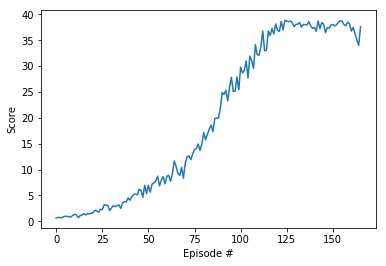

In [13]:
BUFFER_SIZE = int(1e6)        # replay buffer size
BATCH_SIZE = 128              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-3               # learning rate of the actor 
LR_CRITIC = 1e-3              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 10
DDPG_UPDATE_EVERY = 20

NOISE_EPSILON = 1.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-6    # decay rate for noise process

ACTOR_DROPOUT = False         # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.1      # Actor: dropout rate
ACTOR_NORMALIZE = True

CRITIC_DROPOUT = False        # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.05    # Critic: dropout rate
CRITIC_NORMALIZE = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

agent = Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, 
              ac1=256, ac2=128, cc1=256, cc2=128)
scores = ddpg(500, 1000, early_break = True)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Summary

The solution was found after 66 episodes, in 66-165 episodes. Basing on the plot, the performance of the agent seems to be rather stable after 125th episode and the score oscilates between 35 and 40. The training time however is quite long - it took over 1 hour on machine with CUDA-compatible GPU.